生成单个数据集。
数据集的大小为10000且训练集大小为7000，测试集大小为3000。
数据集的样本特征维度p为500，且服从如下的高维线性函数：

In [5]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.data import TensorDataset ,DataLoader
from sklearn.model_selection import train_test_split

In [6]:
num_input,num_example = 500,10000
true_w = torch.tensor(np.ones((num_input,1)),dtype = torch.float32)*0.0056
# true_w = torch.ones(500,1)*0.0056
true_b = 0.028
x_data = torch.tensor(np.random.randn(num_example,num_input),dtype = torch.float32)
y_data = torch.mm(x_data ,true_w)+true_b
y_data += torch.normal(mean = 0,std = 0.001,size=y_data.size())
# y_dat += torch.tensor(np.random.normal(0, 0.01, size=y_data.size()), dtype=torch.float)
train_x,test_x,train_y,test_y = train_test_split(x_data,y_data,shuffle=True,test_size=0.3)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

torch.Size([7000, 500])
torch.Size([7000, 1])
torch.Size([3000, 500])
torch.Size([3000, 1])


In [7]:
batch_size = 50
train_datasets = TensorDataset(train_x,train_y)
train_iter = DataLoader(
    dataset = train_datasets,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)
test_datasets = TensorDataset(test_x,test_y)
test_iter = DataLoader(
    dataset = test_datasets,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0
)

前馈

In [8]:
num_hiddens , num_output = 256,1
w1 = torch.normal(mean = 0,std = 0.001,size = (num_hiddens,num_input), dtype=torch.float32)
b1 = torch.ones(1,dtype = torch.float32)

w2 = torch.normal(mean = 0,std = 0.001,size = (num_output,num_hiddens), dtype=torch.float32)
b2 = torch.ones(1,dtype = torch.float32)
params = [w1,w2,b1,b2]
for param in params:
    param.requires_grad_(requires_grad=True)

In [9]:
def ReLU(X):
    return torch.max(X,other = torch.tensor(0.0))

In [10]:
def DNN(x):
    H = ReLU(torch.matmul(x,w1.t())+b1)
    H = ReLU(torch.matmul(H,w2.t())+b2)
    return H

In [11]:
loss = torch.nn.MSELoss()
def SGD(paras,lr,batch_size):
    for param in params:
        param.data -= lr*param.grad/batch_size

In [12]:
def train(model,train_iter,loss,num_epochs,batch_size,lr,optimizer =None):
    train_ls ,test_ls = [],[]
    for epoch in range(num_epochs):
        train_ls_sum,train_acc_num,n = 0,0,0
        for x ,y in train_iter:
            y_pred = model(x)
            l = loss(y_pred,y)
            if params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            SGD(params,lr,batch_size)
        train_ls.append(loss(model(train_x),train_y).item())
        test_ls.append(loss(model(test_x),test_y).item())
        print('epoch %d, train_loss %.6f,test_loss %f'%(epoch+1, train_ls[epoch],test_ls[epoch]))
    return train_ls,test_ls

In [15]:
lr = 0.001
num_epochs = 20
train_loss ,test_lss =train(DNN,train_iter,loss,num_epochs,batch_size,lr)

epoch 1, train_loss 0.015226,test_loss 0.015414
epoch 2, train_loss 0.015225,test_loss 0.015415
epoch 3, train_loss 0.015225,test_loss 0.015420
epoch 4, train_loss 0.015224,test_loss 0.015413
epoch 5, train_loss 0.015223,test_loss 0.015411
epoch 6, train_loss 0.015222,test_loss 0.015412
epoch 7, train_loss 0.015221,test_loss 0.015415
epoch 8, train_loss 0.015221,test_loss 0.015411
epoch 9, train_loss 0.015220,test_loss 0.015412
epoch 10, train_loss 0.015219,test_loss 0.015413
epoch 11, train_loss 0.015218,test_loss 0.015412
epoch 12, train_loss 0.015219,test_loss 0.015421
epoch 13, train_loss 0.015217,test_loss 0.015413
epoch 14, train_loss 0.015217,test_loss 0.015400
epoch 15, train_loss 0.015216,test_loss 0.015402
epoch 16, train_loss 0.015214,test_loss 0.015406
epoch 17, train_loss 0.015214,test_loss 0.015409
epoch 18, train_loss 0.015213,test_loss 0.015409
epoch 19, train_loss 0.015212,test_loss 0.015405
epoch 20, train_loss 0.015211,test_loss 0.015401


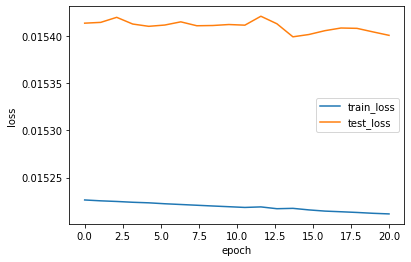

In [16]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_lss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

nn

In [17]:
from torch.nn import init
from collections import OrderedDict

model= nn.Sequential(OrderedDict([
    ('linear1',nn.Linear(num_input,256)),
    ('linear2',nn.Linear(256,128)),
    ('linear3',nn.Linear(128,1)),
])
)
for param in model.parameters():
    init.normal_(param,mean = 0 ,std = 0.001)

In [18]:
lr = 0.001
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(),lr)

In [19]:
def train(model,train_iter,test_iter,loss,num_epochs,batch_size,lr):
    train_ls,test_ls = [],[]
    for epoch in range(num_epochs):
        train_ls_sum ,test_ls_sum = 0,0
        for x,y in train_iter:
            y_pred = model(x)
            l = loss(y_pred,y)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            train_ls_sum += l.item()
        for x ,y in test_iter:
            y_pred = model(x)
            l = loss(y_pred,y)
            test_ls_sum +=l.item()
        train_ls.append(train_ls_sum)
        test_ls.append(test_ls_sum)
        print('epoch %d,train_loss %.6f,test_loss %f'%(epoch+1, train_ls[epoch],test_ls[epoch]))
    return train_ls,test_ls

In [20]:
num_epochs = 20
train_loss ,test_loss = train(model,train_iter,test_iter,loss,num_epochs,batch_size,lr)

epoch 1,train_loss 2.262241,test_loss 0.981726
epoch 2,train_loss 2.226134,test_loss 0.967472
epoch 3,train_loss 2.205567,test_loss 0.958891
epoch 4,train_loss 2.193948,test_loss 0.953661
epoch 5,train_loss 2.187356,test_loss 0.950361
epoch 6,train_loss 2.183606,test_loss 0.948326
epoch 7,train_loss 2.181414,test_loss 0.946903
epoch 8,train_loss 2.180176,test_loss 0.946047
epoch 9,train_loss 2.179482,test_loss 0.945422
epoch 10,train_loss 2.179086,test_loss 0.945008
epoch 11,train_loss 2.178856,test_loss 0.944714
epoch 12,train_loss 2.178728,test_loss 0.944540
epoch 13,train_loss 2.178649,test_loss 0.944380
epoch 14,train_loss 2.178644,test_loss 0.944297
epoch 15,train_loss 2.178608,test_loss 0.944210
epoch 16,train_loss 2.178593,test_loss 0.944161
epoch 17,train_loss 2.178590,test_loss 0.944145
epoch 18,train_loss 2.178580,test_loss 0.944099
epoch 19,train_loss 2.178545,test_loss 0.944107
epoch 20,train_loss 2.178558,test_loss 0.944052


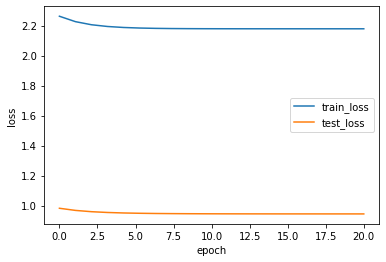

In [21]:
x = np.linspace(0,len(train_loss),len(train_loss))
plt.plot(x,train_loss,label="train_loss",linewidth=1.5)
plt.plot(x,test_loss,label="test_loss",linewidth=1.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()